# Grounded SAM pipeline (2025 version)

This notebook implements Grounded SAM, which is a pipeline that makes bounding box predictions from input text using Grounding DINO model, and then uses Segment Anything with bounding box prompts to generate the segmentation masks.

Output images with segmentation masks are saved to a specified output folder to visualize results.

### Install Requirements

In [1]:
%%capture

!pip install fiftyone==1.1.0
!pip install pyzbar
!pip install opencv-python
!pip install seaborn
!pip install openpyxl
!pip install groundingdino-py
!pip install segment_anything

### Import Required Libraries

In [2]:
import os
import sys
import numpy as np
import pandas as pd
import torch
import fiftyone as fo
import cv2
import matplotlib.pyplot as plt
import PIL
import requests

from pathlib import Path
from PIL import Image, ImageOps, ImageDraw, ImageFont
from PIL.ExifTags import TAGS
from pyzbar.pyzbar import decode, ZBarSymbol
from torchvision import transforms
from torchvision.ops import box_convert
from IPython.display import display
import argparse
import copy
from io import BytesIO

from detectron2 import model_zoo
from detectron2.utils.logger import setup_logger
from detectron2.engine import DefaultPredictor
from detectron2.data.catalog import Metadata
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer, ColorMode

import groundingdino.datasets.transforms as T
from groundingdino.models import build_model
from groundingdino.util import box_ops
from groundingdino.util.slconfig import SLConfig
from groundingdino.util.utils import clean_state_dict, get_phrases_from_posmap
from groundingdino.util.inference import annotate, load_image, predict

import supervision as sv
from segment_anything import build_sam, SamPredictor
from huggingface_hub import hf_hub_download
from pycocotools.coco import COCO

# Set up the logger for detectron2
setup_logger()


/opt/conda/lib/python3.10/site-packages/torchvision/datapoints/__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
/opt/conda/lib/python3.10/site-packages/torchvision/transforms/v2/__init__.py:54: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https:/

<Logger detectron2 (DEBUG)>

### Load Grounding Dino Model


Load the Grounding DINO Model which will be used to predict bounding boxes, given a text prompt.

In [3]:
def load_model_hf(repo_id, filename, ckpt_config_filename, device='cpu'):
    cache_config_file = hf_hub_download(repo_id=repo_id, filename=ckpt_config_filename)

    args = SLConfig.fromfile(cache_config_file) 
    model = build_model(args)
    args.device = device

    cache_file = hf_hub_download(repo_id=repo_id, filename=filename)
    checkpoint = torch.load(cache_file, map_location='cpu')
    log = model.load_state_dict(clean_state_dict(checkpoint['model']), strict=False)
    print("Model loaded from {} \n => {}".format(cache_file, log))
    _ = model.eval()
    return model


ckpt_repo_id = "ShilongLiu/GroundingDINO"
ckpt_filenmae = "groundingdino_swinb_cogcoor.pth"
ckpt_config_filename = "GroundingDINO_SwinB.cfg.py"

groundingdino_model = load_model_hf(ckpt_repo_id, ckpt_filenmae, ckpt_config_filename)

GroundingDINO_SwinB.cfg.py:   0%|          | 0.00/1.01k [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


final text_encoder_type: bert-base-uncased


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

groundingdino_swinb_cogcoor.pth:   0%|          | 0.00/938M [00:00<?, ?B/s]

Model loaded from /home/jovyan/.cache/huggingface/hub/models--ShilongLiu--GroundingDINO/snapshots/a94c9b567a2a374598f05c584e96798a170c56fb/groundingdino_swinb_cogcoor.pth 
 => _IncompatibleKeys(missing_keys=[], unexpected_keys=['label_enc.weight', 'bert.embeddings.position_ids'])


### Load Segment Anything Model (SAM)

Segment Anything will be used to generate segmentation leaves for detected leaf bounding boxes from Grounding DINO output.

In [6]:
! wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

--2024-06-24 20:05:00--  https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 18.155.173.116, 18.155.173.40, 18.155.173.79, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|18.155.173.116|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2564550879 (2.4G) [binary/octet-stream]
Saving to: ‘sam_vit_h_4b8939.pth.3’

sam_vit_h_4b8939.pt 100%[===================>]   2.39G   102MB/s    in 23s     

2024-06-24 20:05:23 (104 MB/s) - ‘sam_vit_h_4b8939.pth.3’ saved [2564550879/2564550879]



In [4]:
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

sam_checkpoint = 'sam_vit_h_4b8939.pth'
sam = build_sam(checkpoint=sam_checkpoint)
sam.to(device=DEVICE)
sam_predictor = SamPredictor(sam)

### Initialize Functions for Evaluation

In [57]:
import numpy as np

def iou(gtmask, test_mask):
    intersection = np.logical_and(gtmask, test_mask)
    union = np.logical_or(gtmask, test_mask)
    iou_score = np.sum(intersection) / np.sum(union)
    return (iou_score)

# Usually there is a mask for the entire plant in addition to individual leaves. 
# This function attempts to remove the full plant mask by caclculating the iou of each mask and the union of all masks.
def check_full_plant(masks):
    # Initialize the combined mask
    mask_all = np.zeros(masks[0].shape, dtype=np.float32)

    # Combine all masks into one
    for mask in masks:
        mask_all += mask.astype(np.float32)

    iou_withall = []
    # Calculate IoU for each mask with the combined mask
    for mask in masks:
        iou_withall.append(iou(mask, mask_all))

    idx_notall = np.array(iou_withall) < 0.9
    return idx_notall

def annotate_masks_in_image(masks, image, include, random_color=True):
    # Convert image to RGBA
    annotated_frame_pil = Image.fromarray(image).convert("RGBA")

    
    # Iterate through each mask
    for i in range(masks.shape[0]):
        if (include[i]):
            mask = masks[i]
            if random_color:
                color = np.concatenate([np.random.random(3), np.array([0.8])], axis=0)
            else:
                color = np.array([30/255, 144/255, 255/255, 0.6])

            h, w = mask.shape[-2:]
            mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)

            mask_image_pil = Image.fromarray((mask_image * 255).astype(np.uint8)).convert("RGBA")

            # Composite the mask with the image
            annotated_frame_pil = Image.alpha_composite(annotated_frame_pil, mask_image_pil)
    
    return np.array(annotated_frame_pil)

# Returns relative bbox for FiftyOne and cropped mask
def get_bbox_for_plant(file_name):
    
    image_id = next(img['id'] for img in coco_data['images'] if img['file_name'] == file_name)

    # Get annotations for the image ID with label 'leaf'
    leaf_annotations = [ann for ann in coco_data['annotations'] if ann['image_id'] == image_id and coco_data['categories'][ann['category_id']]['name'] == 'leaf']

    # Calculate the bounding box that encompasses all leaf annotations
    if leaf_annotations:
        x_min = min(ann['bbox'][0] for ann in leaf_annotations)
        y_min = min(ann['bbox'][1] for ann in leaf_annotations)
        x_max = max(ann['bbox'][0] + ann['bbox'][2] for ann in leaf_annotations)
        y_max = max(ann['bbox'][1] + ann['bbox'][3] for ann in leaf_annotations)
        plant_bbox = [x_min, y_min, x_max - x_min, y_max - y_min]
    else:
        plant_bbox = None

    return plant_bbox

def convert_bbox_to_full_image(bbox_cropped, bbox_full_image):
    x_min_cropped, y_min_cropped, width_cropped, height_cropped = bbox_cropped
    x_min_full, y_min_full, width_full, height_full = bbox_full_image

    x_min = x_min_full + x_min_cropped
    y_min = y_min_full + y_min_cropped
    x_max = x_min + width_cropped
    y_max = y_min + height_cropped

    return x_min, y_min, x_max, y_max

def adjust_mask(mask_cropped, bbox_cropped, full_image_shape):

    x_min_cropped, y_min_cropped, width_cropped, height_cropped = bbox_cropped
    full_image_height, full_image_width = full_image_shape[:2]

    if len(mask_cropped.shape) == 3 and mask_cropped.shape[0] == 1:
        mask_cropped = mask_cropped[0]

    # Create an empty mask for the full image
    mask_full = np.zeros((full_image_height, full_image_width), dtype=bool)

    # Determine the location in the full image where the cropped mask should be placed
    x_min_full = int(x_min_cropped)
    y_min_full = int(y_min_cropped)

    # Place the cropped mask in the corresponding location in the full image mask
    mask_full[y_min_full:y_min_full+mask_cropped.shape[0], x_min_full:x_min_full+mask_cropped.shape[1]] = mask_cropped

    return mask_full



In [8]:
import matplotlib.patches as patches

# x_min: The x-coordinate of the top-left corner of the bounding box.
# y_min: The y-coordinate of the top-left corner of the bounding box.
# width: The width of the bounding box.
# height: The height of the bounding box.

def visualize_bbox(image_path, bbox):
    img = Image.open(image_path)
    fig, ax = plt.subplots(1)
    ax.imshow(img)
    
    rect = patches.Rectangle((bbox[0], bbox[1]), bbox[2], bbox[3], linewidth=2, edgecolor='r', facecolor='none')
    ax.add_patch(rect)

    plt.show()

In [9]:
# Returns relative bbox for FiftyOne and cropped mask
def relative_mask_bbox(mask, file_name, image):
    
    plant_bbox = get_bbox_for_plant(file_name)
    # Assume we have the bbox of the full image
    
    if not plant_bbox:
        plant_bbox = [0, 0, image.shape[1], image.shape[0]]
    
    bbox_full_image = [0, 0, image.shape[1], image.shape[0]]  # Full image bounding box

    # Convert bbox to full image coordinates
    bbox_full = convert_bbox_to_full_image(plant_bbox, bbox_full_image)
    mask_full = adjust_mask(mask, plant_bbox, image.shape)
    

    # Find the coordinates of the nonzero elements in the mask
    nonzero_rows, nonzero_cols = np.nonzero(mask_full)

    # Calculate the bounding box of the leaf
    x_min = np.min(nonzero_cols)
    x_max = np.max(nonzero_cols)
    y_min = np.min(nonzero_rows)
    y_max = np.max(nonzero_rows)

    # Create an array representing the bounding box [x_min, y_min, width, height]
    cropped_mask = mask_full[y_min:y_max, x_min:x_max]\

    return x_min, y_min, x_max, y_max, cropped_mask

        

In [10]:
def is_bbox_large(bbox, threshold=0.9):
    """
    Check if bbox covers a large portion of the image.

    Parameters:
    - bbox: List representing the bounding box [x, y, width, height].
    - threshold: Threshold percentage for considering a bbox as covering a large portion of the image.

    Returns:
    - True if bbox covers a large portion of the image, False otherwise.
    """
    _, _, width, height = bbox
    bbox_area = width * height
    image_area = 1.0  # Assuming image area is 1 (normalized coordinates)
    return bbox_area >= threshold * image_area

def filter_large_bboxes(boxes, threshold=0.9):
    """
    Filter out bounding boxes that cover a large portion of the image.

    Parameters:
    - boxes: Tensor of bounding boxes in the format (left, top, width, height).
    - image_size: Tuple representing the size of the image (width, height).
    - threshold: Threshold percentage for considering a bbox as covering a large portion of the image.

    Returns:
    - Tensor of bounding boxes that do not cover a large portion of the image.
    """
    filtered_boxes = []
    for bbox in boxes:
        if not is_bbox_large(bbox, threshold):
            filtered_boxes.append(bbox)
    if len(filtered_boxes) > 0:
        return torch.stack(filtered_boxes)
    else:
        # Return an empty tensor with the same shape as the input boxes
        return torch.empty_like(boxes)

# Running Grounded SAM on your dataset


In [11]:
import json

# name of output folder
output_file_name = '2025_grounded_sam'

data_path = '/home/jovyan/work/data/2024-03-14_leaves'

coco_annotation_path = '/home/jovyan/work/data/2025_leaves.json'
with open(coco_annotation_path) as f:
    coco_data = json.load(f)
    coco_annotations = coco_data['annotations']
    coco_images_info = coco_data['images']
    coco_categories = coco_data['categories']

namespace(thing_classes=['leaf', 'qr', 'red-square'])

Next, we load the images and annotations into a FiftyOne dataset.

In [104]:
import numpy as np
from PIL import Image, ImageOps
import fiftyone as fo

dataset = fo.Dataset.from_dir(
    data_path=f"{data_path}",
    labels_path=f"{coco_annotation_path}",
    dataset_type=fo.types.COCODetectionDataset,
    name=f"{today}_grounded_sam",
    label_types="segmentations",
    overwrite=True
)

 100% |█████████████████| 176/176 [46.7s elapsed, 0s remaining, 2.3 samples/s]      


In [105]:
import torch.nn.functional as F
from fiftyone import ViewField as F_fo
import csv

sam_image_dir = '/home/jovyan/work/data/leaves_cropped'
sam_output_folder = '/home/jovyan/work/data/grounded_sam/2025-02-06_prompt1'
save_output_img = False

TEXT_PROMPTS = [
    "leaf",
    "leaf . partial leaf",
    "leaf . long narrow leaf",
    "leaf . long narrow leaf . curled leaf",
    "leaf . partial leaf . curled leaf . red leaf . long narrow leaf",
    "leaf . green leaf with crystals . long narrow leaf . sprouting leaf",
    "leaf . green leaf with crystals . long narrow leaf . sprouting leaf . broad leaf",
    "leaf . green leaf with white texture . long narrow leaf . sprouting leaf . red leaf",
    "leaf . green leaf with white speckles . long narrow leaf . sprouting leaf .  broad leaf . partial leaf . leaf with red tip . curled leaf",
]

BOX_TRESHOLD = 0.3
TEXT_TRESHOLD = 0.25

# Path to save metrics
metrics_csv_path = '/home/jovyan/work/data/grounded_sam/metrics_results.csv'

# Check if the CSV file already exists
file_exists = os.path.isfile(metrics_csv_path)

# Initialize the CSV file with headers if it doesn't exist
if not file_exists:
    with open(metrics_csv_path, mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(['Prompt', 'mAP', 'TP', 'FP', 'FN', 'Precision', 'Recall', 'F1'])

for TEXT_PROMPT in TEXT_PROMPTS:
    
    print(TEXT_PROMPT)

    with fo.ProgressBar() as pb:
        for sample in pb(dataset):

            # Load full image
            image = Image.open(sample.filepath)
            image = ImageOps.exif_transpose(image)  # Ensure correct orientation
            image_arr = np.array(image)
            h, w, _ = image_arr.shape

            # --------------------- Grounding Dino --------------------
            file_name = os.path.basename(sample.filepath)
            name, ext = os.path.splitext(file_name)


            # get cropped images
            file_path = f"{sam_image_dir}/{name}_cropped{ext}"

            # if cropped image exists, use it
            if os.path.exists(file_path):
                image_source, dino_image = load_image(file_path)
            # otherwise, use full image
            else:
                image_source, dino_image = load_image(sample.filepath)
                # update to use full image
                file_path = sample.filepath

            # Get prediction bboxes from Grounding DINO
            boxes, logits, phrases = predict(
                model=groundingdino_model,
                image=dino_image,
                caption=TEXT_PROMPT,
                box_threshold=BOX_TRESHOLD,
                text_threshold=TEXT_TRESHOLD,
                device=DEVICE
            )

            boxes = filter_large_bboxes(boxes, threshold=0.9)

            if os.path.exists(file_path) and save_output_img:
                # Annotate image with bounding boxes
                annotated_frame = annotate(image_source=image_source, boxes=boxes, logits=logits, phrases=phrases)
                annotated_frame = annotated_frame[..., ::-1]  # Convert BGR to RGB

                # Save Grouding DINO bbox visualization to image
                dino_result = Image.fromarray(annotated_frame)
                dino_result.save(os.path.join(sam_output_folder, f"{name}_dino_bboxes.png"))

            # Set image for SAM
            sam_predictor.set_image(image_source)

            # Convert box format and apply transformations
            H, W, _ = image_source.shape
            boxes_xyxy = box_ops.box_cxcywh_to_xyxy(boxes) * torch.Tensor([W, H, W, H])
            transformed_boxes = sam_predictor.transform.apply_boxes_torch(boxes_xyxy, image_source.shape[:2]).to(DEVICE)

            # Initialize list of FiftyOne detections for grounded sam predictions
            grounded_sam_detections = []

            if transformed_boxes.size(0) > 0:
                masks, _, _ = sam_predictor.predict_torch(
                    point_coords=None,
                    point_labels=None,
                    boxes=transformed_boxes,
                    multimask_output=False,
                )

                masks_cpu = masks.cpu().numpy()
                idx_not_full_plant = check_full_plant(masks_cpu)

                if save_output_img:
                    original_image = Image.open(file_path)
                    image_array = np.array(original_image)
                    annotated_frame_with_mask = annotate_masks_in_image(
                        masks_cpu,
                        image_array,
                        idx_not_full_plant
                    )
                    output_image = Image.fromarray(annotated_frame_with_mask)
                    output_image.save(f"{sam_output_folder}/{name}_grounded_sam_masks.png")

                # Add Grounded SAM detections to FiftyOne dataset
                for i in range(masks.shape[0]):
                    if idx_not_full_plant[i]:
                        mask = masks[i].cpu().numpy()

                        x1, y1, x2, y2, bbox_mask = relative_mask_bbox(mask, file_name, image_arr)

                        # Get confidence store
                        confidence =  float(logits[i])
                        label = phrases[i]

                        grounded_sam_detections.append(fo.Detection(
                            label=label,
                            bounding_box=[
                                min(x1, x2) / image.width,
                                min(y1, y2) / image.height,
                                abs(x2 - x1) / image.width,
                                abs(y2 - y1) / image.height
                            ],
                            mask=bbox_mask,
                            confidence=confidence
                        ))

            # Update sample with Grounded SAM detections
            sample["grounded_sam_predictions"] = fo.Detections(detections=grounded_sam_detections)
            sample["height"] = h
            sample["width"] = w
            sample.tags.append(os.path.basename(sample.filepath))
            sample.save()
        
    # List unique classes in the predicted labels
    unique_pred_classes = dataset.distinct("grounded_sam_predictions.detections.label")
    print("Predicted Classes:", unique_pred_classes)
    
    # Replace all leaf-related detection's labels with "leaf"
    mapping = {k: "leaf" for k in unique_pred_classes}
    normalized_view = dataset.map_labels("grounded_sam_predictions", mapping)

    counts = normalized_view.count_values("grounded_sam_predictions.detections.label")
    print(counts["leaf"])

    # Filter ground truth to include only 'leaf' detections
    leaf_view = normalized_view.filter_labels("ground_truth", F_fo("label") == "leaf")

    # Evaluate detections treating all as 'leaf'
    results = leaf_view.evaluate_detections(
        "grounded_sam_predictions",  # Normalized predictions field in the cloned dataset
        gt_field="ground_truth",     # Ground truth field
        compute_mAP=True,
        eval_key="eval"
    )

    # Get mAP for 'leaf' class
    map_score = results.mAP()
    tp = leaf_view.sum("eval_tp")
    fp = leaf_view.sum("eval_fp")
    fn = leaf_view.sum("eval_fn")

    # Calculate Precision, Recall, and F1
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0.0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0.0
    f1_score = (2 * precision * recall) / (precision + recall) if (precision + recall) > 0 else 0.0

    # Append metrics to CSV
    with open(metrics_csv_path, mode='a', newline='') as file:
        writer = csv.writer(file)
        writer.writerow([TEXT_PROMPT, map_score, tp, fp, fn, precision, recall, f1_score])

    
    


leaf
   0% ||----------------|   0/176 [17.5ms elapsed, ? remaining, ? samples/s] 

/opt/conda/lib/python3.10/site-packages/transformers/modeling_utils.py:1044: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


  12% |██---------------|  22/176 [22.7s elapsed, 2.7m remaining, 0.9 samples/s] 

/tmp/ipykernel_82/1864294252.py:6: RuntimeWarning: invalid value encountered in scalar divide
  iou_score = np.sum(intersection) / np.sum(union)


 100% |█████████████████| 176/176 [3.6m elapsed, 0s remaining, 0.7 samples/s]    
Predicted Classes: ['leaf']
417
Evaluating detections...
 100% |█████████████████| 169/169 [7.5s elapsed, 0s remaining, 13.2 samples/s]      
Performing IoU sweep...
 100% |█████████████████| 169/169 [2.4s elapsed, 0s remaining, 58.1 samples/s]          
leaf . partial leaf
 100% |█████████████████| 176/176 [3.8m elapsed, 0s remaining, 0.7 samples/s]      
Predicted Classes: ['leaf', 'leaf leaf', 'leaf partial', 'leaf partial leaf', 'partial leaf']
529
Evaluating detections...
 100% |█████████████████| 169/169 [7.7s elapsed, 0s remaining, 12.8 samples/s]      
Performing IoU sweep...
 100% |█████████████████| 169/169 [2.7s elapsed, 0s remaining, 54.8 samples/s]      
leaf . long narrow leaf
 100% |█████████████████| 176/176 [3.7m elapsed, 0s remaining, 0.7 samples/s]      
Predicted Classes: ['leaf', 'leaf leaf', 'leaf long narrow leaf', 'leaf narrow leaf', 'long narrow leaf', 'narrow leaf']
455
Evaluatin

## Calculate Evaluation metrics

In [94]:
import fiftyone as fo
import fiftyone.zoo as foz
from fiftyone import ViewField as F

# Filter ground truth and predictions to only include 'leaf' detections
leaf_view = dataset.filter_labels("ground_truth", F("label") == "leaf")

# Evaluate detections only for 'leaf' class
results = leaf_view.evaluate_detections(
    "grounded_sam_predictions",  # Predicted detections field
    gt_field="ground_truth",     # Ground truth field
    compute_mAP=True,
    eval_key="eval"
)

# Get mAP for 'leaf' class
map_score = results.mAP()
print(f"Mean Average Precision (mAP) for 'leaf': {map_score:.4f}")

# Print classification report for 'leaf'
results.print_report(classes=["leaf"])

# Print TP, FP, FN specifically for 'leaf'
print("TP (leaf): %d" % leaf_view.sum("eval_tp"))
print("FP (leaf): %d" % leaf_view.sum("eval_fp"))
print("FN (leaf): %d" % leaf_view.sum("eval_fn"))

print(results.metrics())

counts = dataset.count_values("grounded_sam_predictions.detections.label")
print(counts)

Evaluating detections...
 100% |█████████████████| 169/169 [6.4s elapsed, 0s remaining, 17.8 samples/s]      
Performing IoU sweep...
 100% |█████████████████| 169/169 [2.3s elapsed, 0s remaining, 63.9 samples/s]      
Mean Average Precision (mAP) for 'leaf': 0.0081
              precision    recall  f1-score   support

        leaf       0.37      0.02      0.04      1001

   micro avg       0.37      0.02      0.04      1001
   macro avg       0.37      0.02      0.04      1001
weighted avg       0.37      0.02      0.04      1001

TP (leaf): 22
FP (leaf): 479
FN (leaf): 979
{'accuracy': 0.014864864864864866, 'precision': 0.043912175648702596, 'recall': 0.02197802197802198, 'fscore': 0.029294274300932094, 'support': 1001}
{'green leafting leaf curled leaf': 1, 'green leafrouting leaf leaf curled leaf': 1, 'green leaf narrow leafrouting leaf broad leaf curled leaf': 1, 'green leaf broad leaf curled leaf': 3, 'green leafting': 1, 'narrow leaf': 90, '##ting leaf': 1, 'leaf broad leaf le

In [100]:
import fiftyone as fo
from fiftyone import ViewField as F

# Replace all leaf-related detection's labels with "leaf"
mapping = {k: "leaf" for k in unique_pred_classes}
normalized_view = dataset.map_labels("grounded_sam_predictions", mapping)

counts = normalized_view.count_values("grounded_sam_predictions.detections.label")
print(counts["leaf"])

# Filter ground truth to include only 'leaf' detections
leaf_view = normalized_view.filter_labels("ground_truth", F("label") == "leaf")

# Evaluate detections treating all as 'leaf'
results = leaf_view.evaluate_detections(
    "grounded_sam_predictions",  # Normalized predictions field in the cloned dataset
    gt_field="ground_truth",     # Ground truth field
    compute_mAP=True,
    eval_key="eval"
)

# Get mAP for 'leaf' class
map_score = results.mAP()
print(f"Mean Average Precision (mAP) for 'leaf': {map_score:.4f}")

# Print classification report for 'leaf'
results.print_report(classes=["leaf"])

# Print TP, FP, FN specifically for 'leaf'
print("TP (leaf): %d" % leaf_view.sum("eval_tp"))
print("FP (leaf): %d" % leaf_view.sum("eval_fp"))
print("FN (leaf): %d" % leaf_view.sum("eval_fn"))

# Print complete metrics
print(results.metrics())


417
Evaluating detections...
 100% |█████████████████| 169/169 [7.0s elapsed, 0s remaining, 14.4 samples/s]      
Performing IoU sweep...
 100% |█████████████████| 169/169 [2.4s elapsed, 0s remaining, 55.7 samples/s]          
Mean Average Precision (mAP) for 'leaf': 0.3003
              precision    recall  f1-score   support

        leaf       0.96      0.40      0.56      1001

   micro avg       0.96      0.40      0.56      1001
   macro avg       0.96      0.40      0.56      1001
weighted avg       0.96      0.40      0.56      1001

TP (leaf): 399
FP (leaf): 18
FN (leaf): 602
{'accuracy': 0.3915603532875368, 'precision': 0.9568345323741008, 'recall': 0.3986013986013986, 'fscore': 0.5627644569816643, 'support': 1001}


In [86]:
import numpy as np
import matplotlib.pyplot as plt

# FiftyOne stores its 
def convert_to_pixels(bbox, height, width):
    x1, y1, w, h = bbox
    return [x1 * width, y1 * height, (x1 + w) * width, (y1 + h) * height]

def calculate_mask(detections, height, width):

    # rebuild full mask
    mask = np.zeros((height, width), dtype=bool)
    for d in detections:
        if d.label == 'leaf':
            bbox = d.bounding_box
            x1, y1, x2, y2 = convert_to_pixels(bbox, height, width)
            mask[round(y1):round(y2), round(x1):round(x2)] |= d.mask
    return mask

def calculate_iou_and_dice(gt_mask, pred_mask):
    
    intersect = np.logical_and(gt_mask, pred_mask)
    union = np.logical_or(gt_mask, pred_mask)
    intersect_pixels = np.count_nonzero(intersect)
    union_pixels = np.count_nonzero(union)
    
    # Normal IoU and Dice calculation when there are objects
    iou = intersect_pixels / union_pixels if union_pixels else None
    dice = (2 * intersect_pixels) / (np.count_nonzero(gt_mask) + np.count_nonzero(pred_mask)) if np.count_nonzero(gt_mask) + np.count_nonzero(pred_mask) else None
    
    return iou, dice

def visualize_masks(gt_mask, pred_mask):
    f, axarr = plt.subplots(1, 2)
    plt.rcParams['figure.figsize'] = [10, 10]
    axarr[0].title.set_text('Ground Truth')
    axarr[1].title.set_text('Prediction')
    axarr[0].imshow(gt_mask)
    axarr[1].imshow(pred_mask)
    plt.show()


def count_leaves(detections):
    return sum(1 for d in detections if hasattr(d, 'label') and d.label == 'leaf')

    

#### Visualize single sample and test metrics

IMG_6056.JPG


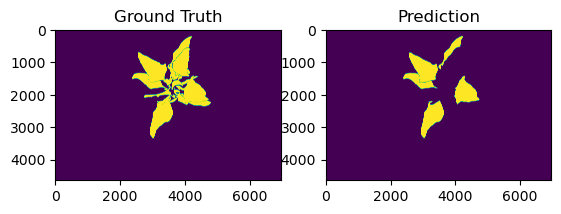

In [34]:
sample = dataset.last()
print(sample.filename)
height, width = sample.height, sample.width
ground_truth_mask = calculate_mask(sample.ground_truth.detections, height, width)
prediction_mask = calculate_mask(sample.grounded_sam_predictions.detections, height, width)
visualize_masks(ground_truth_mask, prediction_mask)

In [54]:
import pandas as pd

# initialize dataframe from manual area file, and add column for ml_area
df = pd.read_excel('/home/jovyan/work/data/manual_area_count.xlsx')

columns_to_initialize = ['grounded_sam_area', 'ml_leaf_count', 'ground_truth_pixels', 'prediction_pixels', 'iou', 'dice', 'count_precision', 'count_recall', 'num_matches', 'tp', 'fp', 'fn',  'mask_precision', 'mask_recall']

# Initialize columns to None and then convert to float
for column in columns_to_initialize:
    df[column] = None
    df[column] = df[column].astype(float)
    
missing_from_file = []

with fo.ProgressBar() as pb:
    
    iou_list = []
    dice_list = []
    
    for sample in pb(dataset):

        filename = sample.filepath.split('/')[-1].split('.')[0]
        ground_truth_detections = sample.ground_truth.detections
        prediction_detections = sample.grounded_sam_predictions.detections

        ground_truth_mask = calculate_mask(ground_truth_detections, height, width)
        prediction_mask = calculate_mask(prediction_detections, height, width)
        leaf_pixels = np.count_nonzero(prediction_mask)

        height, width = sample.height, sample.width
        iou, dice = calculate_iou_and_dice(ground_truth_mask, prediction_mask)

        row = df['picture'].str.startswith(filename)

        df.loc[row, 'ground_truth_pixels'] = np.count_nonzero(ground_truth_mask)
        df.loc[row, 'prediction_pixels'] = np.count_nonzero(prediction_mask)
        df.loc[row, 'iou'] = round(iou, 3) if iou is not None else None
        df.loc[row, 'dice'] = round(dice, 3) if dice is not None else None

        iou_list.append(iou)
        dice_list.append(dice)


    iou_list = np.array(iou_list, dtype=float)


    print('Min IOU: ', np.nanmin(iou_list))
    print('Max IOU: ', np.nanmax(iou_list))
    print('Average IOU: ', np.nanmean(iou_list))

    print('\n')
    dice_list = np.array(dice_list, dtype=float)
    print('Min Dice: ', np.nanmin(dice_list))
    print('Max Dice: ', np.nanmax(dice_list))
    print('Average Dice: ', np.nanmean(dice_list))


# df_area = df[df['ml_area'] >= 0.0]
# pd.set_option('display.max_rows', None)  # None means unlimited
# pd.set_option('display.max_columns', None)

# # Calculate means for specific columns
# mean_values = {
#     'ground_truth_pixels': None,
#     'prediction_pixels': None,
#     'iou': np.nanmean(df['iou']),
#     'dice': np.nanmean(df['dice']),
#     'count_precision': df['count_precision'].mean(),
#     'count_recall': df['count_recall'].mean(),
#     'mask_precision': df['mask_precision'].mean(),
#     'mask_recall': df['mask_recall'].mean(),
#     'num_matches': None,
# }

# # Create a new DataFrame with the mean values
# mean_df = pd.DataFrame(mean_values, index=['average'])

# # Append the new DataFrame with averages to the original DataFrame
# df = pd.concat([df, mean_df])


# # Specify the path and name of the CSV file you want to create
# csv_file_path = f'{sam_output_folder}/{output_folder_name}.csv'

# # Export the DataFrame to CSV
# df.to_csv(csv_file_path, index=False)


 100% |█████████████████| 176/176 [9.9s elapsed, 0s remaining, 17.1 samples/s]      
Min IOU:  0.0
Max IOU:  0.9639692621343997
Average IOU:  0.5092665798679746


Min Dice:  0.0
Max Dice:  0.9816541233306051
Average Dice:  0.5740785251656847


In [21]:
session = fo.launch_app(datasets['fold_0'], port=5151, address="0.0.0.0")

Connected to FiftyOne on port 5151 at 0.0.0.0.
If you are not connecting to a remote session, you may need to start a new session and specify a port


In [164]:
session.refresh()